In [28]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammeddalkran/masked-facerecognition")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4


In [29]:
import os

# Path where the dataset is downloaded
dataset_path = "/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4"  # Replace with actual path

# List files and directories inside the dataset
files = os.listdir(dataset_path)

# Print the list of files and directories
for file in files:
    print(file)


AFDB_masked_face_dataset
AFDB_face_dataset


Previewing 3 unmasked images from /root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset:


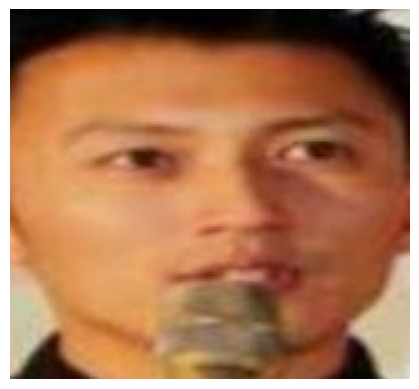

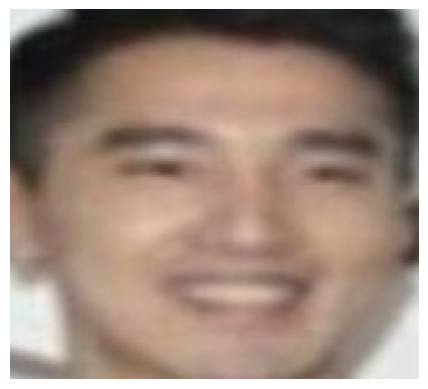

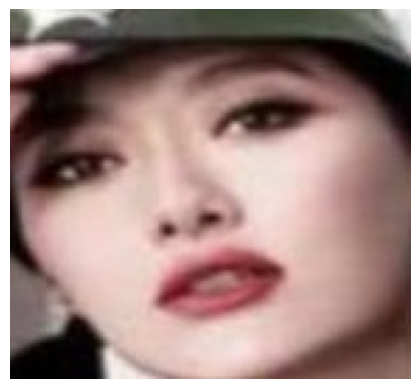

Total number of unmasked images: 90468


In [30]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Define the path to unmasked face dataset
unmasked_path = os.path.join(dataset_path, 'AFDB_face_dataset')

# List all files in the unmasked dataset directory
def get_image_files(folder_path):
    image_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):  # Check for common image extensions
                image_files.append(os.path.join(root, file))
    return image_files

# Get all image files in the unmasked dataset
unmasked_files = get_image_files(unmasked_path)

# Randomly pick a few images to preview
def preview_images(file_list):
    for _ in range(3):  # Preview 3 random images
        random_image = random.choice(file_list)
        img = Image.open(random_image)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Preview images from the unmasked dataset
print(f"Previewing 3 unmasked images from {unmasked_path}:")
preview_images(unmasked_files)

# Print the total number of unmasked images
print(f"Total number of unmasked images: {len(unmasked_files)}")


In [31]:
import random

# Sampling a subset of the images (e.g., 1,000 images)
subset_size = 10000  # Adjust as needed
subset_files = random.sample(unmasked_files, subset_size)
# Verify the selected subset
print(f"Sample of 10,000 unmasked image file paths:")
print(subset_files[:5])  # Display the first 5 file paths



Sample of 10,000 unmasked image file paths:
['/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset/AFDB_face_dataset/yingcaier/1_0_yingcaier_0104.jpg', '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset/AFDB_face_dataset/guojingfei/1_0_guojingfei_0173.jpg', '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset/AFDB_face_dataset/yanggongru/0_0_yanggongru_0143.jpg', '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset/AFDB_face_dataset/linyun/1_0_linyun_0040.jpg', '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_face_dataset/AFDB_face_dataset/gaoyixiang/1_0_gaoyixiang_0241.jpg']


In [32]:
import random
from PIL import Image
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader,random_split


# Assuming unmasked_files contains the file paths of your images
subset_size = 10000  # Adjust as needed
subset_files = random.sample(unmasked_files, subset_size)

# Define the transformation pipeline with augmentation
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])


# Custom dataset class to load images
class FaceDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB format

        # Apply transformations (augmentation and normalization)
        if self.transform:
            image = self.transform(image)

        return image

# Create a DataLoader for the subset of images
dataset = FaceDataset(subset_files, transform=transform)

# Define the split sizes
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle the test set

# Print the sizes to confirm
print(f"Train set size: {len(train_dataset)}, Test set size: {len(test_dataset)}")


Train set size: 9000, Test set size: 1000


In [33]:
from torchvision.models import resnet50, ResNet50_Weights

class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained Resnet model."""
        super(resnet_feature_extractor, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False



        # Hook to extract feature maps
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map on self.featured."""
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)
        self.model.layer3[-1].register_forward_hook(hook)

    def forward(self, input):

        self.features = []
        with torch.no_grad():
            _ = self.model(input)

        self.avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2]         # Feature map sizes h, w
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        patch = torch.cat(resized_maps, 1)            # Merge the resized feature maps

        return patch

Layer 2 feature map shape: torch.Size([1, 512, 28, 28])
Layer 3 feature map shape: torch.Size([1, 1024, 14, 14])
Concatenated feature map shape: torch.Size([1, 1536, 28, 28])


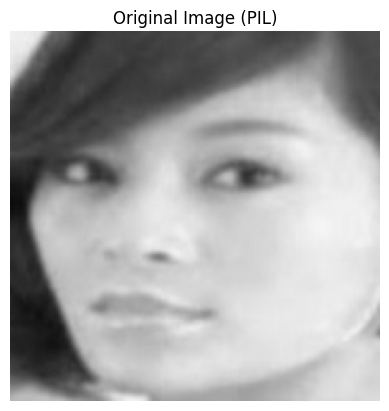

In [34]:
import torch
from torchvision.transforms import ToTensor, Resize, Normalize, Compose, ToPILImage
from PIL import Image
import matplotlib.pyplot as plt

# Define the transformation (ResNet50 default)
transform = Compose([
    Resize((224, 224)),  # ResNet expects 224x224 images
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ResNet normalization
])

# Select a single image from the train dataset
sample = train_dataset[0]  # Get the first sample
image = sample[0]  # Extract the image (adjust based on the actual return structure)

# Convert to PIL Image if the image is a tensor
to_pil = ToPILImage()

# If the image is a tensor, check if it is grayscale (1 channel), and convert to RGB if so
if image.ndimension() == 3 and image.shape[0] == 1:  # Single channel (grayscale)
    image = image.repeat(3, 1, 1)  # Repeat the single channel to make it RGB

# Convert to PIL Image
image_pil = to_pil(image)

# Check if the image is already in RGB format
if image_pil.mode != 'RGB':
    image_pil = image_pil.convert('RGB')  # Ensure it's in RGB format

# Apply the transformation and add a batch dimension
image_tensor = transform(image_pil).unsqueeze(0)  # Add batch dimension

# Initialize the feature extractor
backbone = resnet_feature_extractor()

# Extract features
with torch.no_grad():  # Disable gradient calculations for inference
    feature = backbone(image_tensor)

# Print the shapes of the feature maps from layer2 and layer3
print("Layer 2 feature map shape:", backbone.features[0].shape)
print("Layer 3 feature map shape:", backbone.features[1].shape)

# Print the final concatenated feature map shape
print("Concatenated feature map shape:", feature.shape)

# Visualize the image
plt.imshow(image_pil)
plt.title("Original Image (PIL)")
plt.axis("off")
plt.show()


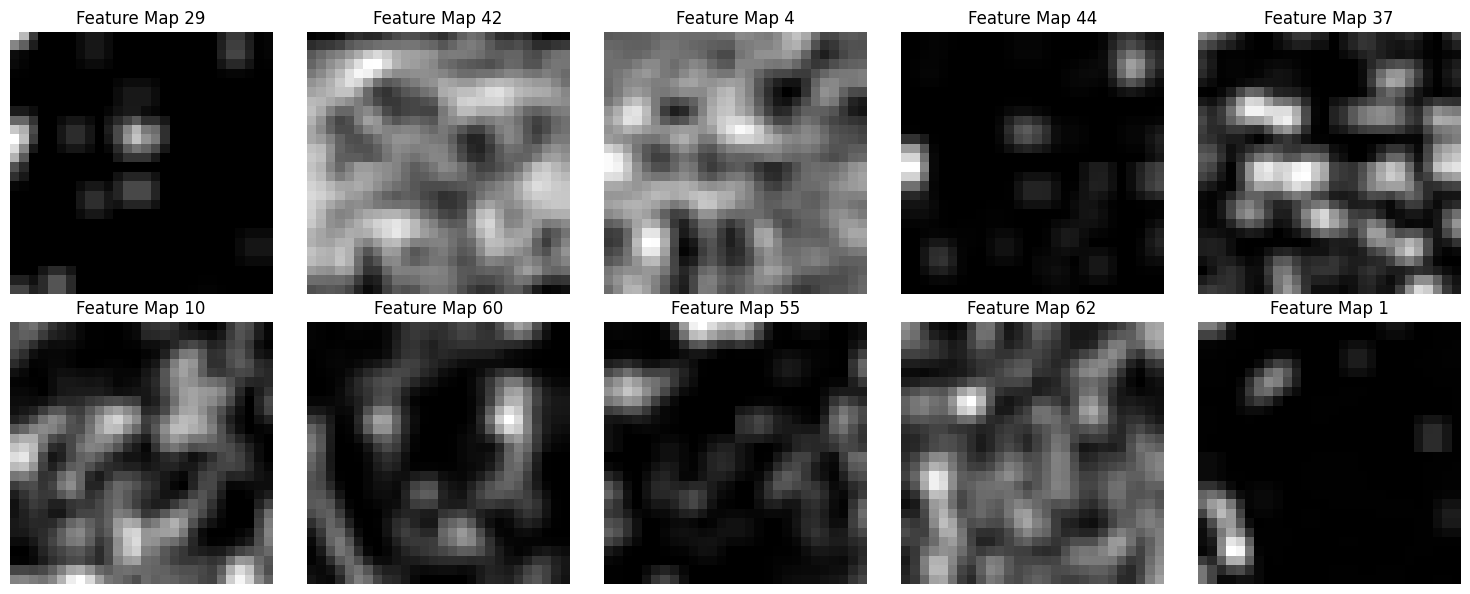

In [35]:
# Select 10 random indices for feature maps
indices = torch.randperm(64)[:10]

# Plot the selected feature maps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(feature[0,idx].detach().cpu(), cmap='gray')
    axes[row, col].set_title(f'Feature Map {idx}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [36]:
import torch.nn as nn

class FeatCAE(nn.Module):
    """Autoencoder."""

    def __init__(self, in_channels=1000, latent_dim=50, is_bn=True):
        super(FeatCAE, self).__init__()

        layers = []
        layers += [nn.Conv2d(in_channels, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, latent_dim, kernel_size=1, stride=1, padding=0)]

        self.encoder = nn.Sequential(*layers)

        # if 1x1 conv to reconstruct the rgb values, we try to learn a linear combination
        # of the features for rgb
        layers = []
        layers += [nn.Conv2d(latent_dim, 2 * latent_dim, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=2 * latent_dim)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d(2 * latent_dim, (in_channels + 2 * latent_dim) // 2, kernel_size=1, stride=1, padding=0)]
        if is_bn:
            layers += [nn.BatchNorm2d(num_features=(in_channels + 2 * latent_dim) // 2)]
        layers += [nn.ReLU()]
        layers += [nn.Conv2d((in_channels + 2 * latent_dim) // 2, in_channels, kernel_size=1, stride=1, padding=0)]
        # layers += [nn.ReLU()]

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [37]:
import torch.optim as optim
model = FeatCAE(in_channels=1536, latent_dim=100).cuda()
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

  2%|▏         | 1/50 [01:15<1:01:17, 75.05s/it]

Epoch [1/50], Loss: 0.0803, Validation Loss: 0.0808


 12%|█▏        | 6/50 [07:26<54:33, 74.40s/it]

Epoch [6/50], Loss: 0.0502, Validation Loss: 0.0512


 22%|██▏       | 11/50 [13:38<48:24, 74.46s/it]

Epoch [11/50], Loss: 0.0453, Validation Loss: 0.0458


 32%|███▏      | 16/50 [19:51<42:12, 74.48s/it]

Epoch [16/50], Loss: 0.0492, Validation Loss: 0.0429


 42%|████▏     | 21/50 [26:03<35:58, 74.43s/it]

Epoch [21/50], Loss: 0.0454, Validation Loss: 0.0417


 52%|█████▏    | 26/50 [32:15<29:48, 74.52s/it]

Epoch [26/50], Loss: 0.0477, Validation Loss: 0.0400


 62%|██████▏   | 31/50 [38:29<23:39, 74.70s/it]

Epoch [31/50], Loss: 0.0389, Validation Loss: 0.0392


 72%|███████▏  | 36/50 [44:42<17:25, 74.69s/it]

Epoch [36/50], Loss: 0.0423, Validation Loss: 0.0384


 82%|████████▏ | 41/50 [50:56<11:11, 74.66s/it]

Epoch [41/50], Loss: 0.0605, Validation Loss: 0.0492


 92%|█████████▏| 46/50 [57:09<04:58, 74.61s/it]

Epoch [46/50], Loss: 0.0435, Validation Loss: 0.0373


100%|██████████| 50/50 [1:02:07<00:00, 74.56s/it]


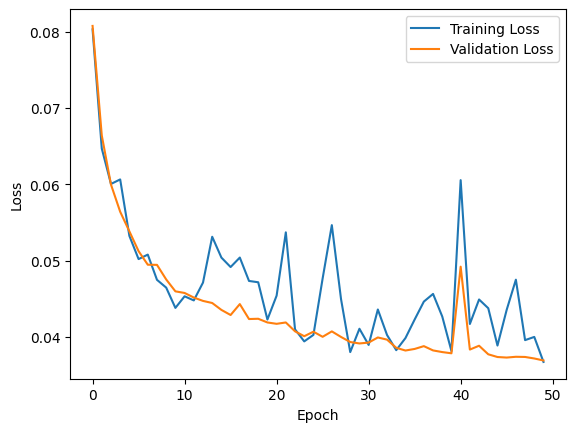

In [ ]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device (GPU or CPU)
model = model.to(device)
backbone = backbone.to(device)

# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []

num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train()
    for data in train_dataloader:
        # Move data to the device
        data = data.to(device)

        with torch.no_grad():
            features = backbone(data)

        # Forward pass
        output = model(features)

        # Compute the loss
        loss = criterion(output, features)

        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    Loss.append(loss.item())

    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for data in test_dataloader:
            # Move data to the device
            data = data.to(device)

            features = backbone(data)
            output = model(features)
            val_loss = criterion(output, features)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)

    if epoch % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss_avg:.4f}')

# Plot training and validation loss
plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'autoencoder_with_resnet_deep_features.pth')


In [ ]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device (GPU or CPU)
ckpoints = torch.load('autoencoder_with_resnet_deep_features.pth')
model.load_state_dict(ckpoints)

model.eval()
model = model.to(device)
backbone = backbone.to(device)

# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []

num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train()
    for data in train_dataloader:
        # Move data to the device
        data = data.to(device)

        with torch.no_grad():
            features = backbone(data)

        # Forward pass
        output = model(features)

        # Compute the loss
        loss = criterion(output, features)

        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    Loss.append(loss.item())

    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for data in test_dataloader:
            # Move data to the device
            data = data.to(device)

            features = backbone(data)
            output = model(features)
            val_loss = criterion(output, features)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)

    if epoch % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss_avg:.4f}')

# Plot training and validation loss
plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'autoencoder_with_resnet_deep_featuresv2.pth')


In [ ]:
from google.colab import files

# Save the model
torch.save(model.state_dict(), 'autoencoder_with_resnet_deep_featuresv2.pth')

# Download the model file
files.download('autoencoder_with_resnet_deep_featuresv2.pth')


In [38]:
# Ensure the same model architecture as during training
model = FeatCAE(in_channels=1536, latent_dim=100).cuda()
backbone.cuda()

# Load the weights into the model
model.load_state_dict(torch.load('autoencoder_with_resnet_deep_featuresv2.pth'))



model.eval()  # Set the model to evaluation mode


<ipython-input-38-e32dcc9f7f02>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('autoencoder_with_resnet_deep_featuresv2.pth'))


FeatCAE(
  (encoder): Sequential(
    (0): Conv2d(1536, 868, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(868, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(868, 200, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(200, 100, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(100, 200, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(200, 868, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(868, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(868, 1536, kernel_size=(1, 1), stride=(1, 1))
  )
)

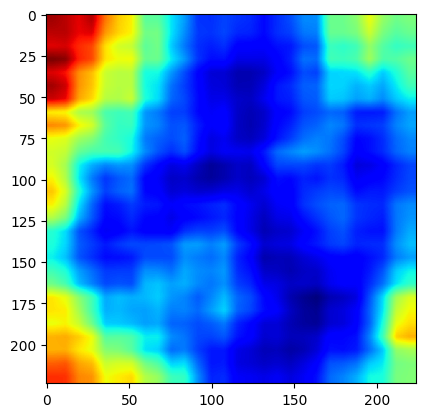

In [39]:
import torch
from torchvision.transforms import ToPILImage, Compose, Resize, ToTensor, Normalize
import matplotlib.pyplot as plt

# Assuming 'train_dataset' is already loaded and the image is a tensor
sample = train_dataset[0]  # Get the first sample
image = sample[0]  # Extract the image

# Convert the image to PIL Image
to_pil = ToPILImage()
image_pil = to_pil(image)

# Check if the image is grayscale (1 channel) and convert to RGB if necessary
if image.ndimension() == 3 and image.shape[0] == 1:  # Single channel (grayscale)
    image = image.repeat(3, 1, 1)  # Repeat the single channel to make it RGB

# Convert to PIL Image again after modification
image_pil = to_pil(image)

# Check if the image is already in RGB format
if image_pil.mode != 'RGB':
    image_pil = image_pil.convert('RGB')  # Ensure it's in RGB format

# Define the transformation
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Typical ImageNet normalization
])

# Apply the transformation and add a batch dimension
image_tensor = transform(image_pil).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

# Pass the image through the backbone (feature extractor)
with torch.no_grad():
    features = backbone(image_tensor)

# Forward pass through the model
recon = model(features)

# Compute the reconstruction error
recon_error = ((features - recon) ** 2).mean(axis=(1)).unsqueeze(0)

# Upscale the error map to match the original input resolution
segm_map = torch.nn.functional.interpolate(
    recon_error,
    size=(224, 224),
    mode='bilinear'
)

# Display the segmentation map
plt.imshow(segm_map.squeeze().detach().cpu().numpy(), cmap='jet')  # Detach before converting to numpy
plt.show()


In [40]:
def decision_function(segm_map):

    mean_top_10_values = []

    for map in segm_map:
        # Flatten the tensor
        flattened_tensor = map.reshape(-1)

        # Sort the flattened tensor along the feature dimension (descending order)
        sorted_tensor, _ = torch.sort(flattened_tensor,descending=True)

        # Take the top 10 values along the feature dimension
        mean_top_10_value = sorted_tensor[:10].mean()

        mean_top_10_values.append(mean_top_10_value)

    return torch.stack(mean_top_10_values)

In [41]:
model.eval()

RECON_ERROR=[]
for data in train_dataloader:

    with torch.no_grad():
        features = backbone(data.cuda()).squeeze()
        # Forward pass
        recon = model(features)
    # Compute the loss
    segm_map =  ((features-recon)**2).mean(axis=(1))[:,3:-3,3:-3]
    anomaly_score = decision_function(segm_map)
    # anomaly_score = segm_map.mean(axis=(1,2))

    RECON_ERROR.append(anomaly_score)

RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

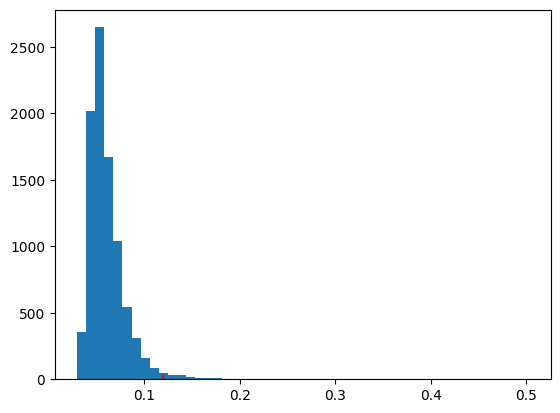

In [42]:
import numpy as np
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

heat_map_max, heat_map_min = np.max(RECON_ERROR), np.min(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

In [43]:
# List to store reconstruction errors for the test dataset
RECON_ERROR_TEST = []

# Switch the model to evaluation mode
model.eval()

# Iterate over the test dataset
for data in test_dataloader:
    with torch.no_grad():
        # Get features from the backbone and remove the unnecessary dimensions
        features = backbone(data.cuda()).squeeze()

        # Forward pass through the model to get the reconstruction
        recon = model(features)

    # Compute the reconstruction error
    segm_map = ((features - recon) ** 2).mean(axis=1)[:, 3:-3, 3:-3]  # Remove borders (if necessary)

    # Use the decision function to calculate the anomaly score
    anomaly_score = decision_function(segm_map)

    # Append the anomaly scores to the list
    RECON_ERROR_TEST.append(anomaly_score)

# Concatenate all the anomaly scores into one array
RECON_ERROR_TEST = torch.cat(RECON_ERROR_TEST).cpu().numpy()


In [44]:
# Calculate the threshold (mean + 3 * standard deviation)
best_threshold_test = np.mean(RECON_ERROR_TEST) + 3 * np.std(RECON_ERROR_TEST)


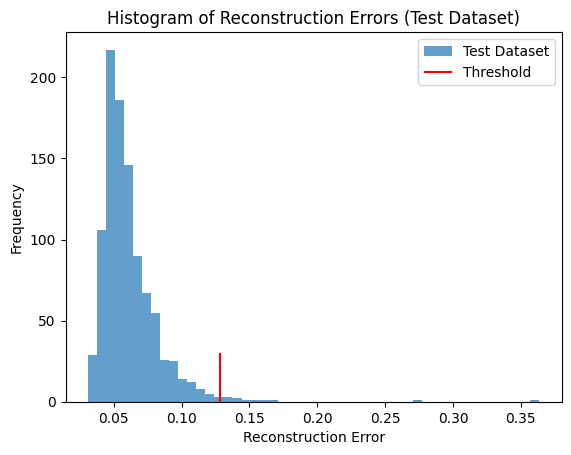

In [45]:
# Plot the histogram of reconstruction errors for the test dataset
plt.hist(RECON_ERROR_TEST, bins=50, alpha=0.7, label='Test Dataset')

# Add a vertical line for the best threshold
plt.vlines(x=best_threshold_test, ymin=0, ymax=30, color='r', label='Threshold')

# Optional: Add labels and legend
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors (Test Dataset)')
plt.legend()

# Show the plot
plt.show()


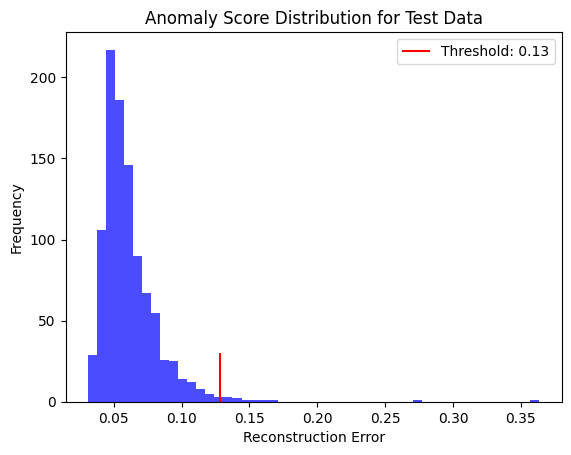

Number of anomalies detected: 12


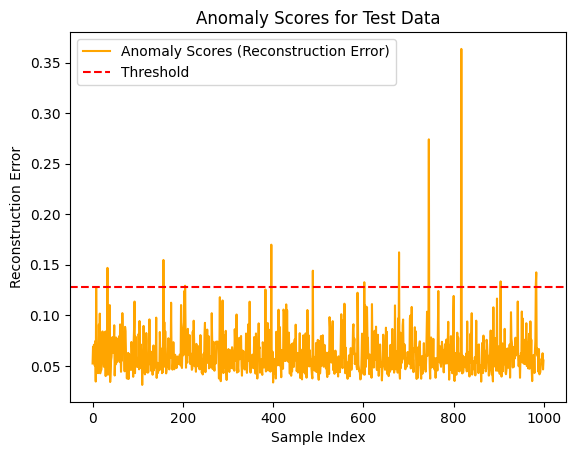

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming RECON_ERROR_TEST contains the reconstruction errors for the test dataset

# Use the best threshold determined from the training data
# Anomaly detection based on the threshold
y_pred_test = (RECON_ERROR_TEST > best_threshold_test).astype(int)  # 1 for anomaly, 0 for normal

# Visualize the anomaly scores (RECON_ERROR_TEST)
plt.hist(RECON_ERROR_TEST, bins=50, color='blue', alpha=0.7)
plt.vlines(x=best_threshold_test, ymin=0, ymax=30, color='r', label=f'Threshold: {best_threshold_test:.2f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Anomaly Score Distribution for Test Data')
plt.show()

# Check how many samples are flagged as anomalies
num_anomalies = np.sum(y_pred_test)
print(f"Number of anomalies detected: {num_anomalies}")

# Optionally, plot the anomaly scores over the test samples
plt.plot(RECON_ERROR_TEST, label='Anomaly Scores (Reconstruction Error)', color='orange')
plt.axhline(y=best_threshold_test, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.title('Anomaly Scores for Test Data')
plt.show()


Previewing 3 masked images from /root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset:


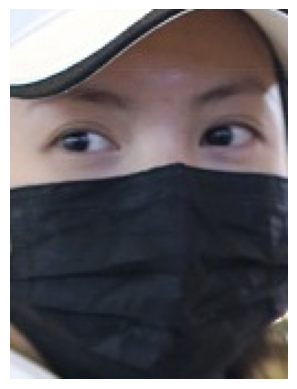

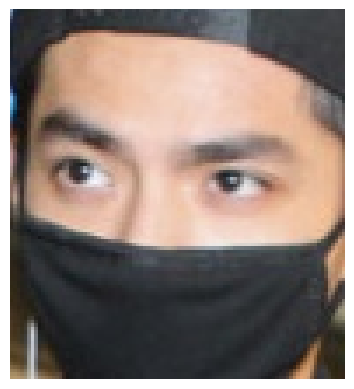

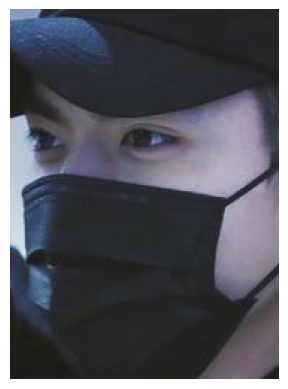

Total number of masked images: 1396


In [47]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Define the path to unmasked face dataset
masked_path = os.path.join(dataset_path, 'AFDB_masked_face_dataset')

# List all files in the unmasked dataset directory
def get_image_files(folder_path):
    image_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):  # Check for common image extensions
                image_files.append(os.path.join(root, file))
    return image_files

# Get all image files in the unmasked dataset
masked_files = get_image_files(masked_path)

# Randomly pick a few images to preview
def preview_images(file_list):
    for _ in range(3):  # Preview 3 random images
        random_image = random.choice(file_list)
        img = Image.open(random_image)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Preview images from the unmasked dataset
print(f"Previewing 3 masked images from {masked_path}:")
preview_images(masked_files)

# Print the total number of unmasked images
print(f"Total number of masked images: {len(masked_files)}")


In [83]:
import random

# Sampling a subset of the images (e.g., 1,000 images)
subset_size = 100  # Adjust as needed
subset_files = random.sample(masked_files, subset_size)
# Verify the selected subset
print(f"Sample of 1000 unmasked image file paths:")
print(subset_files[:5])  # Display the first 5 file paths



Sample of 1000 unmasked image file paths:
['/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/linyoujia/0_0_1.jpg', '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/matianyu/0_0_5.jpg', '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/lidaimo/0_0_3.jpg', '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/linjing/0_0_0.jpeg', '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/denglun/0_1_8.jpg']


In [49]:
print(f"Number of masked images found: {len(masked_files)}")


Number of masked images found: 1396


Anomaly scores for the masked images: [0.22749829292297363, 0.2407364398241043, 0.34881165623664856, 0.17146213352680206, 0.2630328834056854, 0.21778349578380585, 0.13296601176261902, 0.24061794579029083, 0.20762550830841064, 0.18164633214473724, 0.17526906728744507, 0.16639132797718048, 0.29119524359703064, 0.22587943077087402, 0.28292909264564514, 0.1618507355451584, 0.2748977839946747, 0.20764556527137756, 0.2366197556257248, 0.2368636578321457, 0.20997701585292816, 0.25685301423072815, 0.26063141226768494, 0.1860714703798294, 0.2752562463283539, 0.2991176247596741, 0.17361724376678467, 0.18560057878494263, 0.22959132492542267, 0.21907953917980194, 0.2470274269580841, 0.35417982935905457, 0.2679087221622467, 0.25420400500297546, 0.4064624011516571, 0.18000727891921997, 0.23901863396167755, 0.1555914729833603, 0.2573029100894928, 0.30534932017326355, 0.18031619489192963, 0.35027146339416504, 0.2524259388446808, 0.2654312551021576, 0.19167688488960266, 0.31405895948410034, 0.238624855

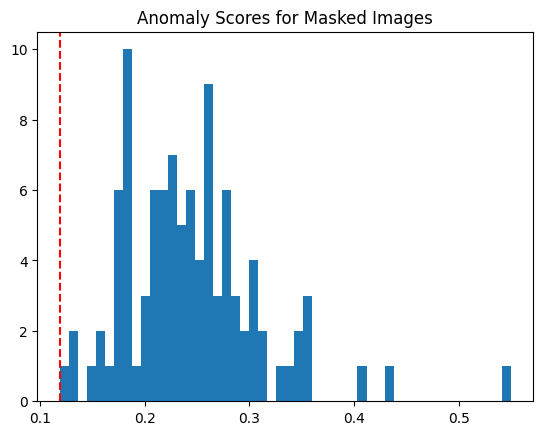

In [54]:
import torch
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import matplotlib.pyplot as plt

def process_image(image_path, model, backbone, best_threshold):
    # Open the image
    img = Image.open(image_path)

    # Apply the same transformations as in your training
    transform = Compose([
        Resize((224, 224)),  # Resizing image (adjust size as per model requirements)
        ToTensor(),  # Convert image to tensor
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Transform the image and add batch dimension
    image_tensor = transform(img).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

    # Debugging: print the shape of the tensor
    # print(f"Input image tensor shape: {image_tensor.shape}")

    # Extract features from the backbone (feature extractor)
    with torch.no_grad():
        features = backbone(image_tensor)  # Now the input has shape (1, C, H, W)

    # Debugging: print the shape of the features
    # print(f"Features shape from backbone: {features.shape}")

    # Forward pass through the model
    recon = model(features)  # Squeeze as required by your model

    # Debugging: print the shape of the reconstruction
    # print(f"Reconstruction shape: {recon.shape}")

    # Compute the reconstruction error
    recon_error = ((features - recon) ** 2).mean(axis=(1))

    # Calculate anomaly score
    anomaly_score = decision_function(recon_error)

    # Compare with best_threshold
    is_anomalous = anomaly_score > best_threshold
    return anomaly_score.item(), is_anomalous

# Loop through the subset of masked images and get the anomaly score
RECON_ERROR_MASKED = []
y_pred_masked = []

for image_path in subset_files:
    anomaly_score, is_anomalous = process_image(image_path, model, backbone, best_threshold)
    RECON_ERROR_MASKED.append(anomaly_score)
    y_pred_masked.append(is_anomalous)

# Now you can evaluate using the anomaly scores and predictions
print("Anomaly scores for the masked images:", RECON_ERROR_MASKED)
print("Predictions (1 for anomaly, 0 for normal):", y_pred_masked)


# Optional: Visualize the results (for the first few samples)
plt.hist(RECON_ERROR_MASKED, bins=50)
plt.axvline(x=best_threshold, color='r', linestyle='--')
plt.title("Anomaly Scores for Masked Images")
plt.show()


In [70]:
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Assuming `model`, `backbone`, and `transform` are already defined and trained,
# and you have the necessary transform for preprocessing

model.eval()
backbone.eval()

# List of test image paths (adjusted from your input)
test_path = [
    '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/jiangwen/0_0_0.png',
    '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/yinengjing/0_0_1.jpg',
    '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/chenxiang/0_0_1.jpg',
    '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/mowenwei/0_0_7.jpg',
    '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/liuxiang/1_0_2.jpg'
]

# Set the best threshold for anomaly detection
best_threshold = 0.05  # Lowered threshold for more anomaly detection
heat_map_min = 0  # Min heatmap value
heat_map_max = 1  # Max heatmap value

# Loop through each image path (no need for .glob(), directly iterate over the list)
for path in test_path:
    path = Path(path)  # Convert string to Path object
    fault_type = path.parts[-2]  # Extract fault type based on folder name
    test_image = Image.open(path)  # Open the image

    # Debug: check the shape of the image
    print(f"Loaded image: {test_image.size}")  # Debugging step

    test_image = transform(test_image).cuda().unsqueeze(0)  # Apply transform and move to GPU

    with torch.no_grad():
        features = backbone(test_image)  # Extract features
        recon = model(features)  # Reconstruct the image

    # Calculate segmentation map (mean squared error between features and reconstruction)
    segm_map = ((features - recon)**2).mean(axis=(1))

    # Apply decision function to get the anomaly score
    y_score_image = decision_function(segm_map=segm_map)

    # Apply threshold to classify the image
    y_pred_image = 1 * (y_score_image >= best_threshold)
    class_label = ['OK', 'NOK']

    # Debug: print the anomaly score
    print(f"Anomaly score: {y_score_image.item()}")  # Debugging step

    if fault_type == 'thread':  # Visualize only for 'thread' fault type (can be extended)
        plt.figure(figsize=(15, 5))

        # Display the input test image (resize for better display)
        plt.subplot(1, 3, 1)
        img_to_display = test_image.squeeze().permute(1, 2, 0).cpu().numpy()
        img_to_display_resized = cv2.resize(img_to_display, (128, 128))  # Resize image for better visibility
        plt.imshow(img_to_display_resized)
        plt.title(f'Fault type: {fault_type}')

        # Normalize heatmap for better visualization (0 to 1 range)
        normalized_heatmap = (segm_map - segm_map.min()) / (segm_map.max() - segm_map.min())

        # Resize the heatmap for better visibility
        normalized_heatmap_resized = cv2.resize(normalized_heatmap.squeeze().cpu().numpy(), (128, 128))

        # Debug: check the shape of the resized heatmap
        print(f"Heatmap shape: {normalized_heatmap_resized.shape}")  # Debugging step

        # Display the anomaly heatmap (resize and apply better contrast)
        plt.subplot(1, 3, 2)
        plt.imshow(normalized_heatmap_resized, cmap='jet', vmin=0, vmax=1)  # Adjusted scaling
        plt.title(f'Anomaly score: {y_score_image.item():0.4f} || {class_label[y_pred_image.item()]}')

        # Display the segmentation map (binary mask)
        plt.subplot(1, 3, 3)
        plt.imshow(normalized_heatmap_resized > best_threshold, cmap='gray')  # Binary mask for segmentation map
        plt.title(f'Segmentation map')

        # Ensure proper layout and plot display
        plt.tight_layout()
        plt.show()


Loaded image: (271, 345)
Anomaly score: 0.09893494844436646
Loaded image: (54, 86)
Anomaly score: 0.06807345896959305
Loaded image: (299, 488)
Anomaly score: 0.14513905346393585
Loaded image: (76, 107)
Anomaly score: 0.06576234102249146
Loaded image: (189, 268)
Anomaly score: 0.09273647516965866


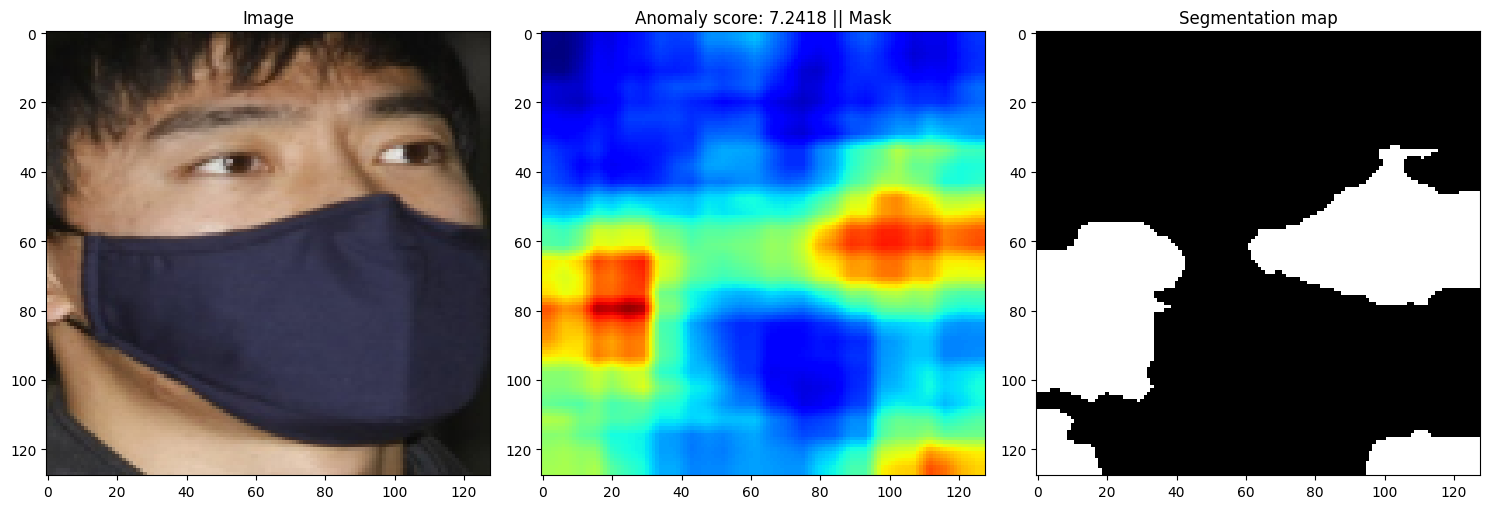

In [82]:
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import numpy as np
import cv2, time
from IPython.display import clear_output


# Assuming `model`, `backbone`, `transform`, `decision_function`, and `best_threshold` are defined

model.eval()
backbone.eval()

test_path = [
    '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/jiangwen/0_0_0.png',
    '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/yinengjing/0_0_1.jpg',
    '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/chenxiang/0_0_1.jpg',
    '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/mowenwei/0_0_7.jpg',
    '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/AFDB_masked_face_dataset/AFDB_masked_face_dataset/liuxiang/1_0_2.jpg'
]

# Loop over each test image path
for path in test_path:
    # Convert the path to a Path object to access parts
    path = Path(path)

    # Load and preprocess the image
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)

    with torch.no_grad():
        # Extract features using the backbone
        features = backbone(test_image)
        # Reconstruct the image using the model
        recon = model(features)

    # Calculate the segmentation map (mean squared error)
    segm_map = ((features - recon)**2).mean(axis=(1))

    # Normalize segm_map to the range [0, 1] for better visualization
    segm_map = segm_map - segm_map.min()
    segm_map = segm_map / segm_map.max()

    # Get the anomaly score using the decision function
    y_score_image = decision_function(segm_map=segm_map)

    # Predict the class based on the threshold (mask = anomaly)
    y_pred_image = 1 * (y_score_image >= best_threshold)
    class_label = ['No_Mask', 'Mask']  # 'No_Mask' is normal, 'Mask' is the anomaly

    # Create the plot
    plt.figure(figsize=(15, 5))

    # Display the test image
    plt.subplot(1, 3, 1)
    img_to_display = test_image.squeeze().permute(1, 2, 0).cpu().numpy()
    img_to_display_resized = cv2.resize(img_to_display, (128, 128))  # Resize for better visibility
    plt.imshow(img_to_display_resized)
    plt.title(f'Image')

    # Display the heatmap (anomaly score)
    plt.subplot(1, 3, 2)
    heat_map = segm_map.squeeze().cpu().numpy()
    heat_map_resized = cv2.resize(heat_map, (128, 128))  # Resize heatmap
    plt.imshow(heat_map_resized, cmap='jet', vmin=0, vmax=1)  # Normalize vmin and vmax for better visualization
    plt.title(f'Anomaly score: {y_score_image.item() / best_threshold:0.4f} || {class_label[int(y_pred_image.item())]}')

    # Display the segmentation map as a binary mask
    plt.subplot(1, 3, 3)
    plt.imshow(heat_map_resized > best_threshold * 10, cmap='gray')  # Binary mask for segmentation
    plt.title(f'Segmentation map')

    # Show the figure
    plt.tight_layout()
    plt.show()

    # Uncomment if you want to pause after each visualization
    time.sleep(0.05)
    clear_output(wait=True)

    # Uncomment to break the loop after one visualization
    # break


In [85]:
import os
import torch
from PIL import Image
from pathlib import Path

# Assuming `model`, `backbone`, `transform`, `decision_function`, `best_threshold` are defined

# Set the model to evaluation mode
model.eval()
backbone.eval()

# Path to the dataset
dataset_path = '/root/.cache/kagglehub/datasets/muhammeddalkran/masked-facerecognition/versions/4/'
masked_path = os.path.join(dataset_path, 'AFDB_masked_face_dataset')

# Get all image paths in the dataset (assuming images are inside subdirectories)
image_paths = []
for root, dirs, files in os.walk(masked_path):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Adjust based on your image extensions
            image_paths.append(os.path.join(root, file))

# Initialize variables for accuracy calculation
correct_predictions = 0
total_predictions = 0

# Loop through all test images
for path in image_paths:
    # Convert the path to a Path object to access parts
    path = Path(path)

    # Load and preprocess the image
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)

    with torch.no_grad():
        # Extract features using the backbone
        features = backbone(test_image)
        # Reconstruct the image using the model
        recon = model(features)

    # Calculate the segmentation map (mean squared error)
    segm_map = ((features - recon)**2).mean(axis=(1))

    # Get the anomaly score using the decision function
    y_score_image = decision_function(segm_map=segm_map)

    # Predict the class based on the threshold (mask = anomaly)
    y_pred_image = 1 * (y_score_image >= best_threshold)
    class_label = ['No Mask', 'Mask']  # 'No Mask' is normal, 'Mask' is the anomaly

    # Ground truth label is always "Mask" (as per your request)
    true_label = 1  # "Mask" is label 1

    # Update the total number of predictions
    total_predictions += 1

    # Check if the predicted label matches the ground truth
    if int(y_pred_image.item()) == true_label:
        correct_predictions += 1

    # Output the prediction
    print(f"Image: {path.name} | Predicted Label: {class_label[int(y_pred_image.item())]} | Ground Truth: {class_label[true_label]}")

# Calculate the accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")


Image: 1_0_13.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_0_0.jpeg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_0_0.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_1_3.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_0_3.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_0_4.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_0_0.png | Predicted Label: Mask | Ground Truth: Mask
Image: 1_0_1.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_0_7.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_0_6.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_0_0.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_0_5.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_0_2.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_0_4.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 0_0_10.jpg | Predicted Label: Mask | Ground Truth: Mask
Image: 1_0_16.jpg | Predicted Label: Mask | Ground Truth: Mask
Imag